# Directionality charts

Here I attempt to make polar bar charts/histograms for different gpx routes, to display how much they go "in the right direction".

In [1]:
import gpxpy
import matplotlib.pyplot as plt

Let's make constants for the routes we want to work with

In [2]:
BHM_TO_STR = "../data/bike/BHM_TO_STR.gpx"
BIC_TO_BED = "../data/bike/BIC_TO_BED.gpx"
BED_TO_SAN = "../data/bike/BED_TO_SAN.gpx"
BIKE_ROUTES = [BHM_TO_STR, BIC_TO_BED, BED_TO_SAN]

Next, functions to load data and display it easily

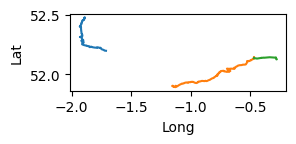

In [6]:
def get_xy_from_gpx(gpx_filename: str):
    gpx_file = open(gpx_filename, 'r')
    gpx = gpxpy.parse(gpx_file)
    x = []
    y = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                x.append(point.longitude)
                y.append(point.latitude)
    return x, y

def show_routes(*coordinates):
    """Show the routes relative to each other.
    Args:
        *coordinates: A list of x and y coordinates.
            i.e., [x1, y1, x2, y2, ..., xn, yn]
    """
    n = len(coordinates) // 2
    fig = plt.figure(figsize=(5, 1))
    ax = fig.add_subplot(111)
    for i in range(n):
        x = coordinates[2*i]
        y = coordinates[2*i+1]
        ax.plot(x, y, '-')
    ax.set_aspect('equal')
    plt.ylabel('Lat')
    plt.xlabel('Long')
    plt.show()

coords = []
for route in BIKE_ROUTES:
    x, y = get_xy_from_gpx(route)
    coords.append(x)
    coords.append(y)
show_routes(*coords)